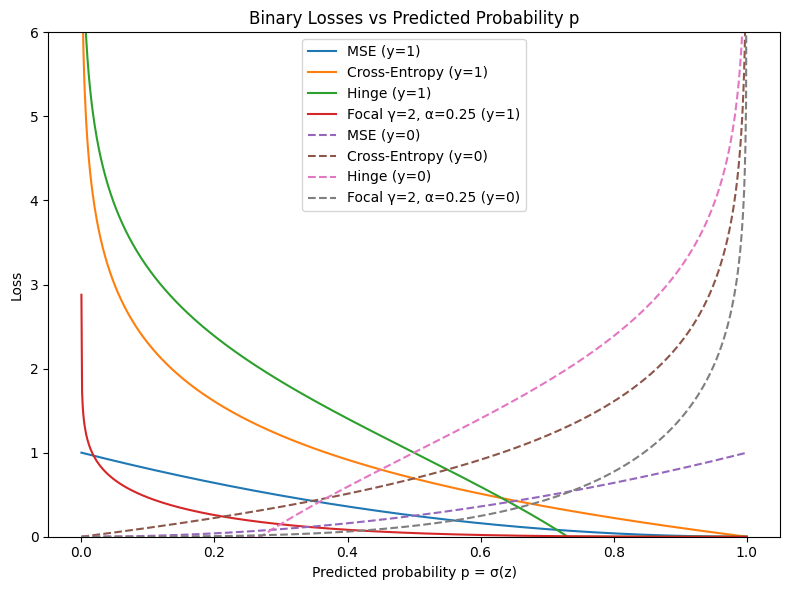

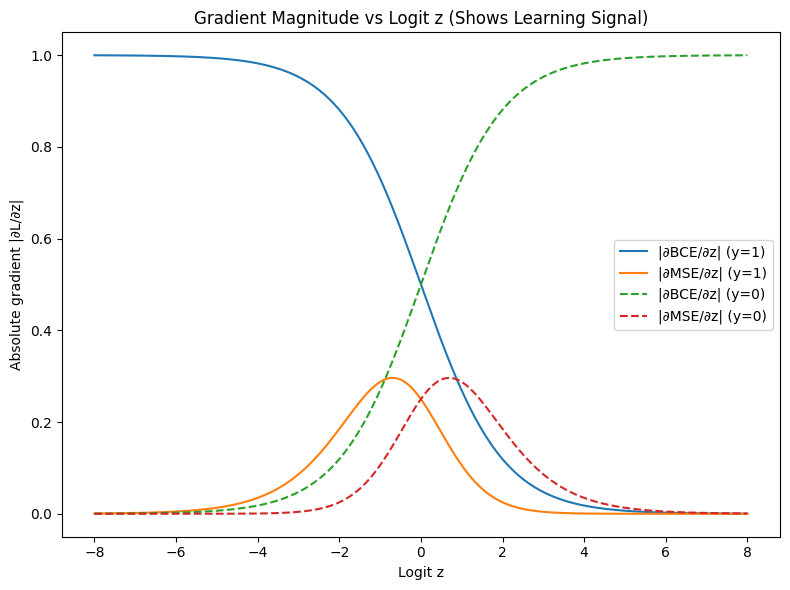

In [3]:

import numpy as np
import matplotlib.pyplot as plt
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logit(p):
    p = np.clip(p, 1e-8, 1-1e-8)
    return np.log(p/(1-p))

def mse_loss(p, y):
    return (p - y)**2

def bce_loss(p, y):
    p = np.clip(p, 1e-12, 1-1e-12)
    return -(y*np.log(p) + (1-y)*np.log(1-p))

def hinge_loss_from_p(p, y):
    """
    Hinge is defined on margins with targets t in {-1,+1} and score z.
    We map probability -> logit for visualization.
    """
    z = logit(p)        # margin proxy
    t = 2*y - 1         # {0,1} -> {-1,+1}
    return np.maximum(0.0, 1 - t*z)

def focal_loss(p, y, gamma=2.0, alpha=0.25):
    p = np.clip(p, 1e-12, 1-1e-12)
    if y == 1:
        return -alpha * (1-p)**gamma * np.log(p)
    else:
        return -(1-alpha) * p**gamma * np.log(1-p)

# ---------- Gradients wrt logit z (training dynamics) ----------
def grad_bce_wrt_z(z, y):
    p = sigmoid(z)
    return (p - y)  # BCE-with-logits: ∂L/∂z = σ(z) - y

def grad_mse_wrt_z(z, y):
    p = sigmoid(z)
    return 2*(p - y) * p*(1-p)  # chain rule through sigmoid

# ==================== PLOT 1: Loss vs predicted probability p ====================
p = np.linspace(1e-5, 1-1e-5, 1000)

plt.figure(figsize=(8, 6))
# y = 1
plt.plot(p, mse_loss(p, 1), label="MSE (y=1)")
plt.plot(p, bce_loss(p, 1), label="Cross-Entropy (y=1)")
plt.plot(p, hinge_loss_from_p(p, 1), label="Hinge (y=1)")
plt.plot(p, [focal_loss(pi, 1, gamma=2.0, alpha=0.25) for pi in p], label="Focal γ=2, α=0.25 (y=1)")
# y = 0
plt.plot(p, mse_loss(p, 0), label="MSE (y=0)", linestyle="--")
plt.plot(p, bce_loss(p, 0), label="Cross-Entropy (y=0)", linestyle="--")
plt.plot(p, hinge_loss_from_p(p, 0), label="Hinge (y=0)", linestyle="--")
plt.plot(p, [focal_loss(pi, 0, gamma=2.0, alpha=0.25) for pi in p], label="Focal γ=2, α=0.25 (y=0)", linestyle="--")

plt.title("Binary Losses vs Predicted Probability p")
plt.xlabel("Predicted probability p = σ(z)")
plt.ylabel("Loss")
plt.ylim(0, 6)
plt.legend()
plt.tight_layout()
plt.show()

# ============== PLOT 2: Absolute gradient vs logit z (learning signal) ==========
z = np.linspace(-8, 8, 400)

plt.figure(figsize=(8, 6))
plt.plot(z, np.abs(grad_bce_wrt_z(z, 1)), label="|∂BCE/∂z| (y=1)")
plt.plot(z, np.abs(grad_mse_wrt_z(z, 1)), label="|∂MSE/∂z| (y=1)")
plt.plot(z, np.abs(grad_bce_wrt_z(z, 0)), label="|∂BCE/∂z| (y=0)", linestyle="--")
plt.plot(z, np.abs(grad_mse_wrt_z(z, 0)), label="|∂MSE/∂z| (y=0)", linestyle="--")

plt.title("Gradient Magnitude vs Logit z (Shows Learning Signal)")
plt.xlabel("Logit z")
plt.ylabel("Absolute gradient |∂L/∂z|")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
import numpy as np

def relu(x):
    return max(x, 0)
def relu_derivative(x):
    mask = x > 0
    x[mask] = 1
    x[~mask] = 0
    return x
def sigmoid_derivative(a):
    return a * (1 - a)

def sigmoid_derivative(z):
    return z * (1 - z)
def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))
def mse_loss(p, y):
    return np.sum((p - y)**2)
def cross_entropy(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.sum(y_true * np.log(y_pred))

In [5]:
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train , y_train), (x_test, y_test) = mnist.load_data()

c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [6]:
x_train_normalized = x_train.reshape(x_train.shape[0], 28 * 28) / 255.0
x_test_normalized = x_test.reshape(x_test.shape[0] ,28 *28) / 255.0

In [19]:
# BasicNeuron
class BasicNeuron:
    def __init__(self, num_inputs, activation_function):
        # small random init to avoid saturation
        self.weights = np.random.randn(num_inputs) * 0.01
        self.bias    = float(np.random.randn() * 0.01)
        self.act_fn  = activation_function

    def forward(self, x):
        x = np.asarray(x).flatten()
        z = np.dot(self.weights, x) + self.bias
        return self.act_fn(z)


# MLP with one hidden layer and backprop
class MLP:
    def __init__(self, num_inputs, num_hidden, num_outputs,
                 hidden_activation='relu',loss='mse', learning_rate=0.001):
        self.lr = learning_rate

        # choose hidden activation
        if hidden_activation == 'relu':
            self.act_h, self.deriv_h = relu, relu_derivative
        elif hidden_activation == 'sigmoid':
            self.act_h, self.deriv_h = sigmoid, sigmoid_derivative
        else:
            raise ValueError("Unsupported hidden activation")
        self.loss = loss
        # hidden layer: list of BasicNeurons
        self.hidden = [
            BasicNeuron(num_inputs, self.act_h)
            for _ in range(num_hidden)
        ]

        # output layer weights & bias (vectorized for softmax)
        # shape: (num_outputs, num_hidden)
        # self.W_out = np.random.randn(num_outputs, num_hidden) * np.sqrt(2.0/num_hidden)
        self.W_out = np.random.randn(num_outputs, num_hidden)
        self.b_out = np.zeros(num_outputs)

    def forward(self, x):
        """
        x: 1-D array of shape (num_inputs,)
        returns: y_pred (1-D array of shape (num_outputs,))
        """
        x = np.asarray(x).flatten()
        self.x = x

        # hidden activations
        h = np.array([neuron.forward(x) for neuron in self.hidden])
        self.h = h  # store for backprop

        # output pre-activations
        z_out = self.W_out.dot(h) + self.b_out
        # output probabilities
        y = softmax(z_out)
        self.y = y  # store for backprop

        return y

    def backward(self, y_true):
        y_true_flatten = y_true.flatten()

        # dL/dy for MSE
        if self.loss == 'mse':
            g = self.y - y_true_flatten                         # shape: (num_outputs,)
            s = float(self.y @ g)                  # scalar = y^T g
            delta_out = self.y * (g - s)           # (diag(y) - y y^T) @ g
        elif self.loss == 'ce':
            delta_out = self.y - y_true_flatten

        # Compute delta_h using pre-update W_out to be textbook-correct
        W_out_before = self.W_out.copy()

        # update output layer
        self.W_out -= self.lr * np.outer(delta_out, self.h)
        self.b_out -= self.lr * delta_out
        avg_g = np.sum(delta_out)
        # backprop into hidden
        delta_h = W_out_before.T @ delta_out
        delta_h *= self.deriv_h(self.h)

        for i, neuron in enumerate(self.hidden):
            neuron.weights -= self.lr * delta_h[i] * self.x
            neuron.bias    -= self.lr * delta_h[i]
        return avg_g

    def train(self, X, Y, epochs=5):
        """
        X: array of shape (n_samples, num_inputs)
        Y: array of shape (n_samples, num_outputs), one-hot labels
        """
        n = len(X)
        epoch_loss = np.zeros(epochs)
        epoch_acc = np.zeros(epochs)
        epoch_avg_grdient = np.zeros(epochs)
        
        for epoch in range(1, epochs+1):
            perm = np.random.permutation(n)
            total_loss = 0.0
            correct = 0
            gradient = []
            for idx in perm:
                x_i = X[idx]
                y_i = Y[idx]

                # forward + loss
                y_pred = self.forward(x_i)
                if self.loss == 'mse':
                    total_loss += mse_loss(y_i, y_pred)
                elif self.loss == "ce":
                    total_loss += cross_entropy(y_i, y_pred)
                else:
                    raise ValueError("Unsupported loss function")

                # accuracy
                if np.argmax(y_pred) == np.argmax(y_i):
                    correct += 1

                # backward
                gradient.append(self.backward(y_i))

            epoch_avg_grdient[epoch-1] = np.mean(gradient)
            avg_loss = total_loss / n
            acc = correct / n
            print(f"Epoch {epoch}/{epochs} — Loss: {avg_loss:.4f}, Acc: {acc:.4f}")
            epoch_loss[epoch-1] = avg_loss
            epoch_acc[epoch-1] = acc

        print("Training complete.")
        return epoch_loss, epoch_acc, epoch_avg_grdient

    def predict(self, x):
        """
        x: single input or array of inputs
        returns: predicted class index or array of indices
        """
        if x.ndim == 1:
            y = self.forward(x)
            return np.argmax(y)
        else:
            return np.array([self.predict(xi) for xi in x])

    def evaluate(self, X, Y):
        """
        X: test inputs, Y: one-hot test labels
        """
        preds = self.predict(X)
        true  = np.argmax(Y, axis=1)
        acc = np.mean(preds == true)
        print(f"Test accuracy: {acc:.4f}")
        return acc


def one_hot(labels, num_classes):
    return np.eye(num_classes)[labels.flatten()]


# Assuming that you have already loaded the MNIST dataset using the code covered previously in the class
Y_train = one_hot(y_train, 10)
Y_test  = one_hot(y_test, 10)

# build MLP: 784 → 64 → 10
mlp_mse = MLP(
    num_inputs=784,
    num_hidden=64,
    num_outputs=10,
    hidden_activation='relu',
    loss='mse',
    learning_rate=0.001
)
mlp_ce = MLP(
    num_inputs=784,
    num_hidden=64,
    num_outputs=10,
    hidden_activation='relu',
    loss='ce',
    learning_rate=0.001
)

# train & evaluate
loss_mse, acc_mse, epoch_avg_grdient_mse = mlp_mse.train(x_train_normalized, Y_train, epochs=10)
loss_ce, acc_ce, epoch_avg_grdient_ce = mlp_ce.train(x_train_normalized, Y_train, epochs=10)
mlp_mse.evaluate(x_test_normalized, Y_test)


Epoch 1/10 — Loss: 0.1393, Acc: 0.9106
Epoch 2/10 — Loss: 0.0829, Acc: 0.9481
Epoch 3/10 — Loss: 0.0685, Acc: 0.9565
Epoch 4/10 — Loss: 0.0601, Acc: 0.9635
Epoch 5/10 — Loss: 0.0546, Acc: 0.9665
Epoch 6/10 — Loss: 0.0496, Acc: 0.9706
Epoch 7/10 — Loss: 0.0465, Acc: 0.9728
Epoch 8/10 — Loss: 0.0435, Acc: 0.9746
Epoch 9/10 — Loss: 0.0411, Acc: 0.9763
Epoch 10/10 — Loss: 0.0388, Acc: 0.9776
Training complete.
Epoch 1/10 — Loss: 0.2497, Acc: 0.9263
Epoch 2/10 — Loss: 0.1434, Acc: 0.9578
Epoch 3/10 — Loss: 0.1125, Acc: 0.9677
Epoch 4/10 — Loss: 0.0955, Acc: 0.9719
Epoch 5/10 — Loss: 0.0833, Acc: 0.9756
Epoch 6/10 — Loss: 0.0727, Acc: 0.9790
Epoch 7/10 — Loss: 0.0659, Acc: 0.9804
Epoch 8/10 — Loss: 0.0593, Acc: 0.9825
Epoch 9/10 — Loss: 0.0541, Acc: 0.9847
Epoch 10/10 — Loss: 0.0499, Acc: 0.9859
Training complete.
Test accuracy: 0.9668


np.float64(0.9668)

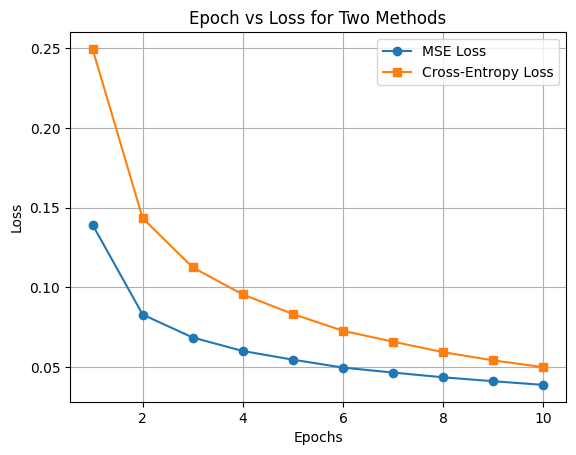

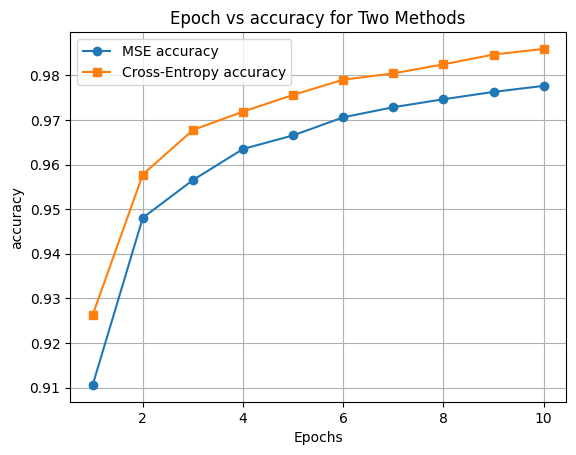

In [20]:
plt.plot(range(1,len(loss_mse)+1), loss_mse, label="MSE Loss", marker="o")
plt.plot(range(1,len(loss_ce)+1), loss_ce,  label="Cross-Entropy Loss", marker="s")

# Labels
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss for Two Methods")

# Show legend (the labels you set in plt.plot)
plt.legend()

# Show grid (optional for clarity)
plt.grid(True)

plt.show()


plt.plot(range(1,len(acc_mse)+1), acc_mse, label="MSE accuracy", marker="o")
plt.plot(range(1,len(acc_ce)+1), acc_ce,  label="Cross-Entropy accuracy", marker="s")

# Labels
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Epoch vs accuracy for Two Methods")

# Show legend (the labels you set in plt.plot)
plt.legend()

# Show grid (optional for clarity)
plt.grid(True)

plt.show()

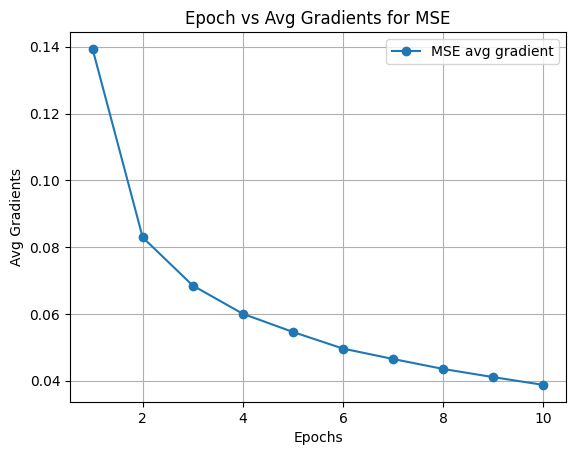

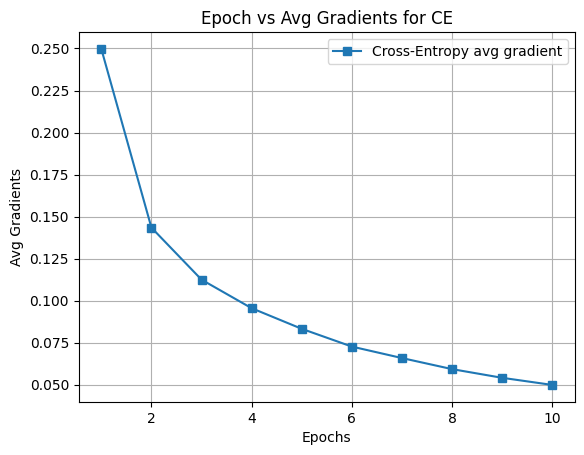

In [22]:
plt.plot(range(1,len(epoch_avg_grdient_mse)+1), loss_mse, label="MSE avg gradient", marker="o")


# Labels
plt.xlabel("Epochs")
plt.ylabel("Avg Gradients")
plt.title("Epoch vs Avg Gradients for MSE")

# Show legend (the labels you set in plt.plot)
plt.legend()

# Show grid (optional for clarity)
plt.grid(True)

plt.show()
plt.plot(range(1,len(epoch_avg_grdient_ce)+1), loss_ce,  label="Cross-Entropy avg gradient", marker="s")

# Labels
plt.xlabel("Epochs")
plt.ylabel("Avg Gradients")
plt.title("Epoch vs Avg Gradients for CE")

# Show legend (the labels you set in plt.plot)
plt.legend()

# Show grid (optional for clarity)
plt.grid(True)

plt.show()

In [12]:

noise_Y_train = Y_train.copy()

n = len(noise_Y_train)
idx = np.random.permutation(n)

for i in idx[:n//10]:  # flip 10% of labels
    y_true = np.argmax(noise_Y_train[i])         # original class
    wrong_classes = list(range(10))
    wrong_classes.remove(y_true)                 # exclude correct one
    new_label = np.random.choice(wrong_classes)  # pick a wrong class
    noise_Y_train[i][y_true] = 0.
    noise_Y_train[i][new_label] = 1.



In [16]:
# build MLP: 784 → 64 → 10
mlp_mse = MLP(
    num_inputs=784,
    num_hidden=64,
    num_outputs=10,
    hidden_activation='relu',
    loss='mse',
    learning_rate=0.001
)
mlp_ce = MLP(
    num_inputs=784,
    num_hidden=64,
    num_outputs=10,
    hidden_activation='relu',
    loss='ce',
    learning_rate=0.001
)

# train & evaluate
loss_mse, acc_mse, epoch_avg_grdient_mse = mlp_mse.train(x_train_normalized, noise_Y_train, epochs=10)
loss_ce, acc_ce, epoch_avg_grdient_ce = mlp_ce.train(x_train_normalized, noise_Y_train, epochs=10)


Epoch 1/10 — Loss: 0.3045, Acc: 0.8186
Epoch 2/10 — Loss: 0.2594, Acc: 0.8542
Epoch 3/10 — Loss: 0.2468, Acc: 0.8639
Epoch 4/10 — Loss: 0.2398, Acc: 0.8689
Epoch 5/10 — Loss: 0.2345, Acc: 0.8731
Epoch 6/10 — Loss: 0.2311, Acc: 0.8750
Epoch 7/10 — Loss: 0.2280, Acc: 0.8775
Epoch 8/10 — Loss: 0.2256, Acc: 0.8791
Epoch 9/10 — Loss: 0.2235, Acc: 0.8809
Epoch 10/10 — Loss: 0.2218, Acc: 0.8823
Training complete.
Epoch 1/10 — Loss: 0.8404, Acc: 0.8211
Epoch 2/10 — Loss: 0.7490, Acc: 0.8510
Epoch 3/10 — Loss: 0.7164, Acc: 0.8582
Epoch 4/10 — Loss: 0.6971, Acc: 0.8626
Epoch 5/10 — Loss: 0.6822, Acc: 0.8657
Epoch 6/10 — Loss: 0.6692, Acc: 0.8677
Epoch 7/10 — Loss: 0.6568, Acc: 0.8700
Epoch 8/10 — Loss: 0.6481, Acc: 0.8709
Epoch 9/10 — Loss: 0.6396, Acc: 0.8716
Epoch 10/10 — Loss: 0.6317, Acc: 0.8734
Training complete.
Test accuracy: 0.9707


np.float64(0.9707)

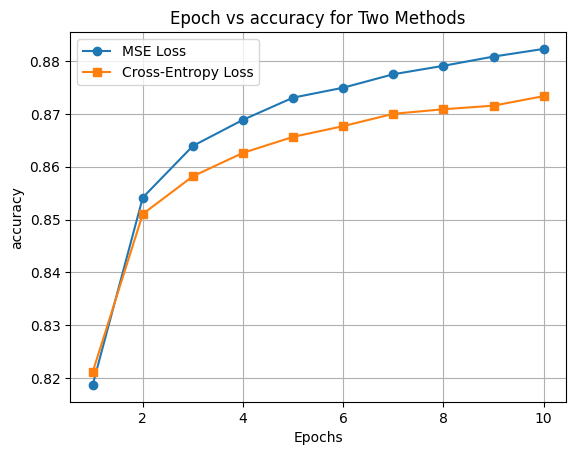

In [18]:
plt.plot(range(1,len(loss_mse)+1), acc_mse, label="MSE Loss", marker="o")
plt.plot(range(1,len(loss_ce)+1), acc_ce,  label="Cross-Entropy Loss", marker="s")

# Labels
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Epoch vs accuracy for Two Methods")

# Show legend (the labels you set in plt.plot)
plt.legend()

# Show grid (optional for clarity)
plt.grid(True)

plt.show()